In [420]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [421]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

Data shape: (344, 7) <class 'pandas.core.frame.DataFrame'>


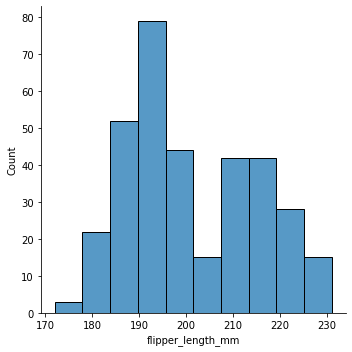

In [422]:
penguins = sns.load_dataset("penguins")
print('Data shape:', penguins.shape, type(penguins))
sns.displot(penguins, x="flipper_length_mm")

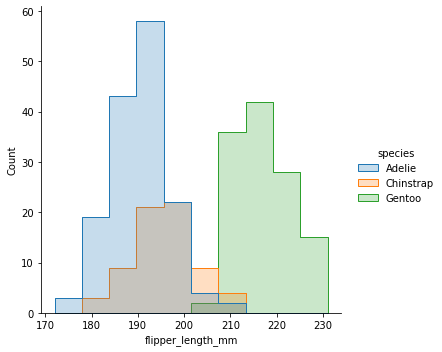

In [423]:
sns.displot(penguins, x="flipper_length_mm", hue="species", element="step")

### H<sub>0</sub>: $\mu$<sub>Adelie</sub> $=$ $\mu$<sub>Chinstrap</sub>
### H<sub>1</sub>: $\mu$<sub>Adelie</sub> $\ne$ $\mu$<sub>Chinstrap</sub>

In [425]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


<br>

## Likelihood ratio test

The likelihood ratio test is

- Reject H<sub>0</sub> if $\Lambda = l(\theta_0 | X)/l(\theta_1 | X) \lt c$

Since log-likelihood is computationally more feasible, we restate the test in terms of log-likelihood:

- Reject H<sub>0</sub> if $-2log(\Lambda) \lt c$
- https://en.wikipedia.org/wiki/Wilks%27_theorem


- What power do we require? <br>
  - If power = 0.8, then P(H<sub>1</sub> | H<sub>1</sub>) = 0.8
  - Instead of analytically determining P(H<sub>1</sub> | H<sub>1</sub>), we can simulate sampling from distributions

In [426]:
# Given H1, the adelie flipper length ~ N(mu_a, sigma_a), and the chinstrap flipper length ~ N(mu_b, sigma_b)

a, b = penguins[penguins.species == 'Adelie'].flipper_length_mm, penguins[penguins.species == 'Chinstrap'].flipper_length_mm
(a.mean(), a.std()**2), (b.mean(), b.std()**2)

((189.95364238410596, 42.76450331125828),
 (195.8235294117647, 50.86391571553993))

$l(\theta) = log(L(\theta)) = log(\Pi_{i=1}^N p(x_i | \theta)) = \sum_{i=1}^N log(p(x_i | \theta))$

Since $p(x_i | \theta) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{- \frac{(x_i - \mu)^2}{2\sigma^2}}$

$l(\theta) = \sum_{i=1}^N log(\frac{1}{\sqrt{2\pi\sigma^2}} e^{- \frac{(x_i - \mu)^2}{2\sigma^2}})$

$ = \frac{-N}{2}log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^N(x_i - \mu)^2$

In [ ]:
def log_like(x, mu, sigma):
    N = len(x)
    return -(N/2)*np.log(2*np.pi*sigma**2) - (1/(2*sigma**2))*sum([(x_i - mu)**2 for x_i in x])

In [427]:
SAMPLE_SCALE = 1

In [428]:
# define sampling on some order of original data cardnality
def get_h1_sample(scale=SAMPLE_SCALE):
    n_a = int(len(a)*scale)
    n_b = int(len(b)*scale)

    sample_a = np.random.normal(size=(n_a,))*a.std() + a.mean()
    sample_b = np.random.normal(size=(n_b,))*b.std() + b.mean()

    sample = pd.DataFrame({
        "species" : ['Adelie']*len(sample_a) + ['Chinstrap']*len(sample_b),
        "flipper_length_mm" : np.concatenate([sample_a, sample_b])
    })
    return sample

In [429]:
# define sampling on some order of original data cardnality
def get_h0_sample(scale=SAMPLE_SCALE):
    n_a = int(len(a)*scale)
    n_b = int(len(b)*scale)

    mu = pd.concat((a, b)).mean()
    sample_a = np.random.normal(size=(n_a,))*a.std() + mu
    sample_b = np.random.normal(size=(n_b,))*b.std() + mu

    sample = pd.DataFrame({
        "species" : ['Adelie']*len(sample_a) + ['Chinstrap']*len(sample_b),
        "flipper_length_mm" : np.concatenate([sample_a, sample_b])
    })
    return sample

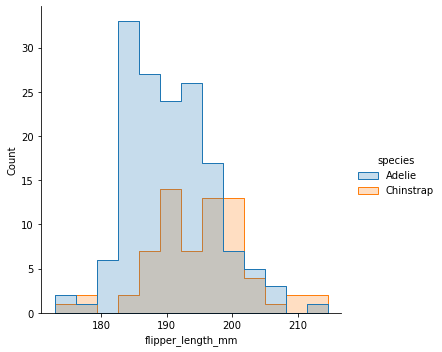

In [430]:
sample = get_h1_sample()
sns.displot(sample, x='flipper_length_mm', hue='species', element="step")

In [431]:
sample.head()

,species,flipper_length_mm
0,Adelie,201.882856
1,Adelie,187.921811
2,Adelie,193.818693
3,Adelie,193.698101
4,Adelie,200.194315


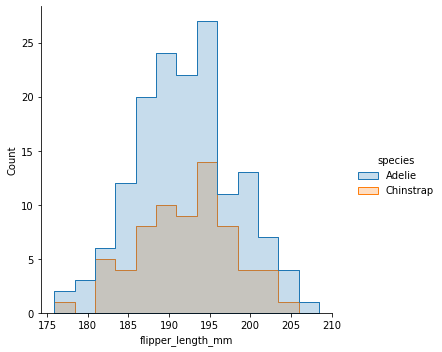

In [439]:
sample = get_h0_sample()
sns.displot(sample, x='flipper_length_mm', hue='species', element="step")

Likelihood of H1 = p1_a(Xa1)*p1_a(Xa2)*...*p1_b(Xb1)*p1_b(Xb2)*...
Likelihood of H0 = p0_a(Xa1)*p0_a(Xa2)*...*p0_b(Xb1)*p0_b(Xb2)*...

In [456]:
def simulate_log_test(c, h0=False, sample=None):
    
    '''
    Log likelihood is the better computational option than computing likelihood
    
    As N -> infinity, L(theta) = p(x1)*p(x2)*...*p(xN) goes to 0, but l(theta) = log(px1) + log(px2) + ... + log(pxN) does not.
    
    Suppose x > 0; as x -> 0, log(x) -> -infinity.
    '''

    # sample data
    if sample is None:
        sample = get_h1_sample() if not h0 else get_h0_sample()
    a = sample[sample.species == 'Adelie'].flipper_length_mm.values
    b = sample[sample.species == 'Chinstrap'].flipper_length_mm.values

    # remove nans
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]

    logger.debug(f'{len(a)} Adelie samples and {len(b)} Chinstrap samples')

    # compute likelihood
    log_likelihood_h1 = log_like(a, a.mean(), a.std()) + log_like(b, b.mean(), b.std())

    # get model distributions
    mu = np.concatenate((a,b)).mean()

    # compute likelihood
    log_likelihood_h0 = log_like(a, mu, a.std()) + log_like(b, mu, b.std())
    
    t_X = -2*(log_likelihood_h0 - log_likelihood_h1)
    return {
        "H0" : t_X < c,
        "t_X" : t_X,
        "L_H0" : log_likelihood_h0,
        "L_H1" : log_likelihood_h1
    }


In [457]:
# how many simulations to draw for H0 and H1
n_simulations = 1000

In [458]:
# run some simulations given H1
test_given_h1 = pd.DataFrame([simulate_log_test(0, h0=False) for _ in range(n_simulations)])

In [459]:
# find what cutoff we need to have the required power
power = 0.8
c_opt = np.percentile(test_given_h1.t_X, (1-power)*100)

In [460]:
# show that desired power is acheived
1 - pd.DataFrame([simulate_log_test(c_opt, h0=False) for _ in range(1000)]).H0.mean()

0.827

### What is the p-value of this test?


- The test advises: reject $H_0$ if $T(X) > c$
  - where $T(X) = -2log(\Lambda)$
- According to [Wilkes Theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem), $T(X)$ follows a chi-squared distribution
  - "...the $\chi^{2}$ distribution has degrees of freedom equal to the difference in dimensionality of $\Theta$ and $\Theta _{0}$ where $\Theta$ is the full parameter space and $ \Theta_{0} $ is the subset of the parameter space associated with $H_0$."
  - Here, $dim(\Theta) = 2$, which are $(\mu_a, \mu_b)$ and $dim(\Theta_{0}) = 1$ with $(\mu)$ 
- Therefore, $p_{value} = P(T(x) > T(X) | H_0)$ where $P$ is a chi-squared distribution with 1 degree of freedom and $X$ is the observed data.
- Similarly, the significance $\alpha = P(T(x) \in H_1 | H_0) = P(T(x) \gt c | H_0)$ where $P$ is a again a chi-squared distribution with 1 degree of freedom.

In [489]:
# under H0, what is the probability that T(x) > c? => 1 - CDF(c)
alpha = 1 - scipy.stats.chi2.cdf(c_opt, df=1)

In [461]:
test_given_h1.head()

,H0,t_X,L_H0,L_H1
0,False,47.796852,-761.820256,-737.921830
1,False,23.954073,-750.347857,-738.370821
2,False,62.802579,-737.331114,-705.929824
3,False,18.880988,-740.916886,-731.476392
4,False,20.806659,-730.875542,-720.472213


In [479]:
# let's see what a histogram of T(X) looks like under the null hypothesis
test_given_h0 = pd.DataFrame([simulate_log_test(c_opt, h0=True) for _ in range(n_simulations)])

In [481]:
# how often would we incorrectly reject the null hypothesis?
(test_given_h0[test_given_h0['H0'] == False]).H0.sum()/len(test_given_h0)

0.0

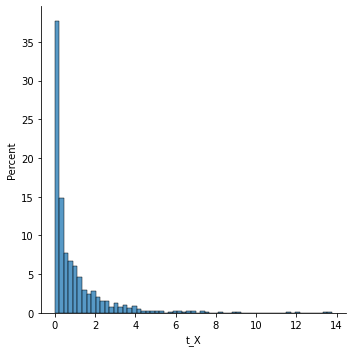

In [463]:
# this looks like a chi-squared with 1 degree of freedom https://en.wikipedia.org/wiki/Chi-squared_distribution
sns.displot(test_given_h0, x='t_X', stat='percent')

In [464]:
# simulated under H_0
p_val_h0 = 1 - scipy.stats.chi2.cdf(np.random.choice(test_given_h0.t_X.values), df=1)

# simulated under H_1
p_val_h1 = 1 - scipy.stats.chi2.cdf(np.random.choice(test_given_h1.t_X.values), df=1)

# we see that we get much better p-values when drawing from the H1-simulated distribution
print('P-value simulated from H1:', p_val_h1)
print('P-value simulated from H0:', p_val_h0)

P-value simulated from H1: 0.00013994777996706453
P-value simulated from H0: 0.8484259372438847


In [465]:
# plot the dist of p-values for each
pval = lambda t_x: 1 - scipy.stats.chi2.cdf(t_x, df=1)
test_given_h0['pval'] = test_given_h0['t_X'].apply(pval)
test_given_h1['pval'] = test_given_h1['t_X'].apply(pval)

pval_df = pd.DataFrame({
    "source" : ['H0']*len(test_given_h0) + ['H1']*len(test_given_h1),
    "p_value" : pd.concat((test_given_h0.pval, test_given_h1.pval)), 
}).reset_index(drop=True)

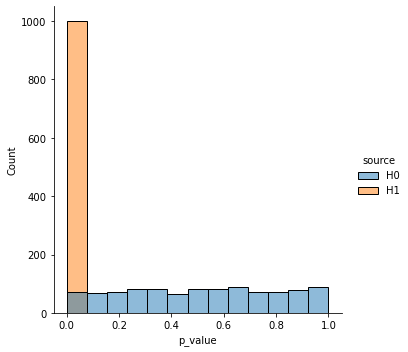

In [466]:
# surely, p-values are lower when the data is actually drawn from H1
sns.displot(pval_df, x='p_value', hue='source')

In [486]:
# with this sample size, how often might we get a "good" p-value under H0?
len(pval_df[(pval_df.source == 'H0') & (pval_df.p_value < 0.05)])/len((pval_df.source == 'H0'))

0.0225

In [491]:
# so, to make a long story short, we reject the null hypothesis and consider this study significant
results = simulate_log_test(c_opt, sample=penguins)
results['pval'] = pval(results['t_X'])
results['significance'] = alpha
results['is_significant'] = results['pval'] < alpha
results

{'H0': False,
 't_X': 34.033631039708325,
 'L_H0': -743.9061897441006,
 'L_H1': -726.8893742242465,
 'pval': 5.41676825616122e-09,
 'significance': 7.879069237048952e-07,
 'is_significant': True}

In [ ]:
# reverse H_1 and H_0?
# p-val as function of N?